In [1]:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:

    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:


import os
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    os.remove(data_path / "pizza_steak_sushi.zip")

train_dir = image_path / "train"
test_dir = image_path / "test"



data/pizza_steak_sushi directory exists.


In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:

from torchvision import transforms
simple_transform = transforms.Compose([
    transforms.Resize((224,224)) ,
    transforms.ToTensor() ,
    transforms.Normalize(mean = [0.485 , 0.456 , 0.406 ] ,
                         std = [0.229 , 0.224 , 0.225])
])

In [5]:

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform= simple_transform , # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bd6a53d2da0>,
 ['pizza', 'steak', 'sushi'])

##MODEL 0

In [6]:
#  ppretrained model

model = torchvision.models.efficientnet_b0(pretrained = True).to(device)

for parm in model.features.parameters() :
  parm.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Adding the classifier Layer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2 , inplace = True)  ,
    torch.nn.Linear(in_features = 1280 ,
                    out_features = output_shape,
                    bias = True ) ).to(device)


In [8]:
## train model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr= 0.001)

torch.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model = model ,
                       train_dataloader = train_dataloader ,
                       test_dataloader = test_dataloader ,
                       optimizer = optimizer ,
                       loss_fn = loss_fn ,
                       epochs = 5 ,
                       device = device)
end_time = timer()

print(f"[INFO] : Total train time {end_time - start_time :.3f} seconds ")



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] : Total train time 15.435 seconds 


In [9]:
# Make predictions
from tqdm.auto import tqdm

test_preds = []
model.eval()

with torch.inference_mode() :
  for x , y in tqdm(test_dataloader) :
    x  , y = x.to(device ) , y.to(device)

    test_logits = model(x)

    test_probs = torch.softmax(test_logits , dim =1 )

    pred_labels = torch.argmax(test_probs, dim =1 )

    test_preds.append(pred_labels )

test_preds = torch.cat(test_preds).cpu()

test_preds


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [10]:
test_truth = torch.cat([y for x , y in test_dataloader])

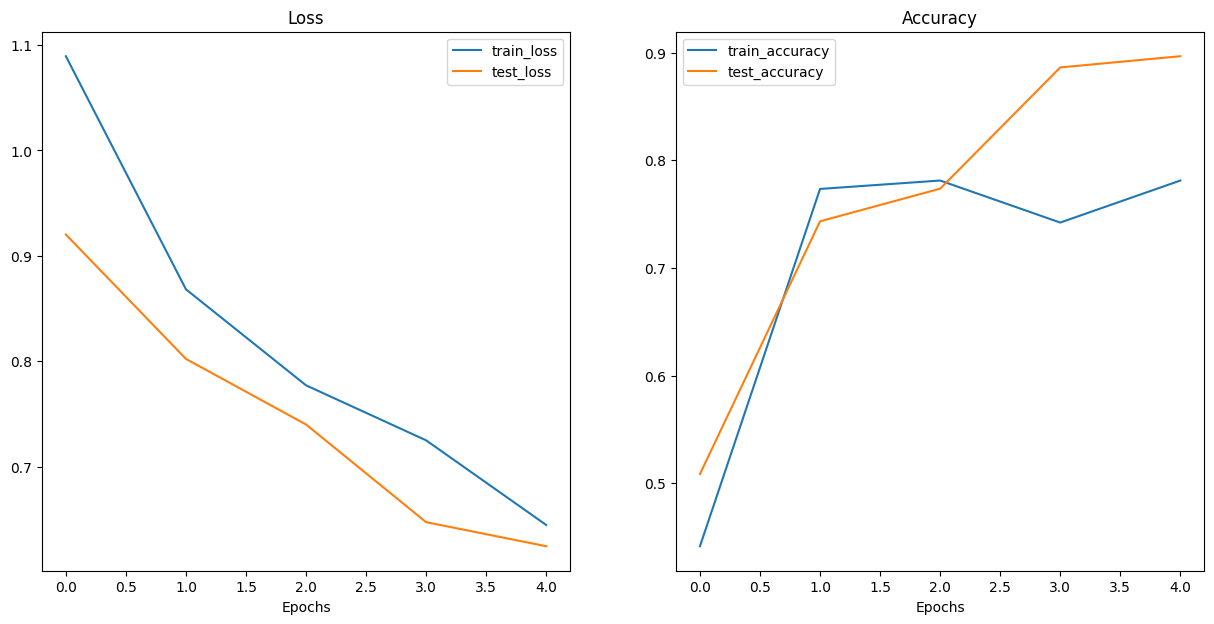

In [11]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [12]:
# torch mtrics

!pip install -q torchmetrics -U mlxtend

import torchmetrics , mlxtend

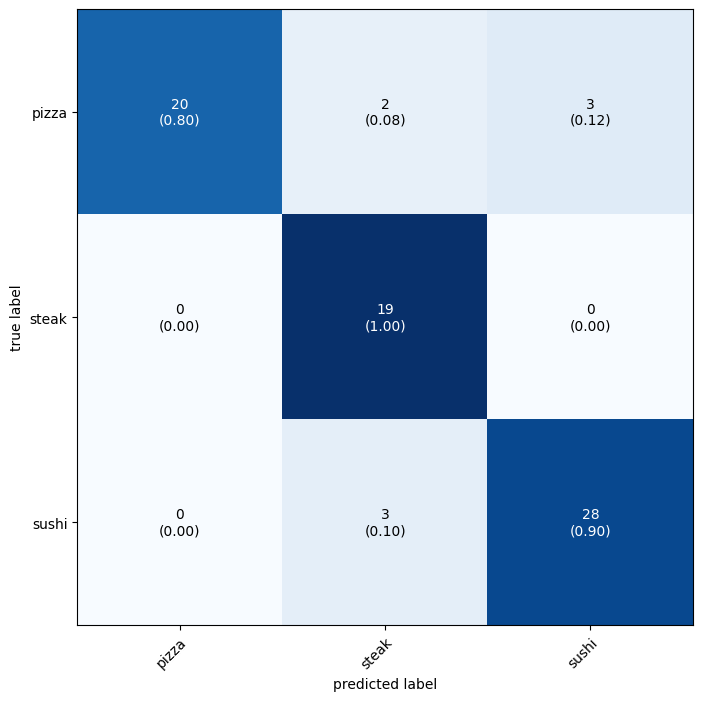

In [13]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_names) , task = 'multiclass')
confmat_tensor = confmat(preds = test_preds , target = test_truth  )


fig , ax  = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy() ,
    figsize = (8 , 8) ,
    class_names = class_names ,
    show_normed = True
)




## Unserstanding wrongly predicted samples

In [14]:
## Lets find the wrongly predicted

from pathlib import Path

test_path = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_path]

def pred_and_store(test_path , model , transform ,  class_names  , device) :
  test_pred = []
  for path in tqdm(test_path)  :

    pred_dict = {}

    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    from PIL import Image

    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.inference_mode() :
      pred_logits = model(transformed_image.to(device))
      pred_probs = torch.softmax(pred_logits , dim =1 )
      pred_labels = torch.argmax(pred_probs , dim =1 )
      pred_class = class_names[pred_labels.cpu()]
      pred_dict["pred_prob"] = pred_probs.unsqueeze(0).max().cpu().item()
      pred_dict["pred_label"] = pred_class

    pred_dict["correct"] = class_name  == pred_class

    # print(pred_dict)

    test_pred.append(pred_dict)

  return test_pred



test_pred_dicts = pred_and_store(test_path , model = model, transform= simple_transform ,   class_names= class_names , device = device )


test_pred_dicts[:2]



  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7877963185310364,
  'pred_label': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.842374861240387,
  'pred_label': 'steak',
  'correct': True}]

In [15]:
import pandas as pd

test_pred_df = pd.DataFrame(test_pred_dicts)
top_5_most_wrong = test_pred_df.sort_values(by = ["correct" , "pred_prob" ]   , ascending = [True , False]
                         ).head(5)

<ipython-input-16-e405aaaa026e>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
<ipython-input-16-e405aaaa026e>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
<ipython-input-16-e405aaaa026e>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_class = row[3]
<ipython-input-16-e405aaaa026e>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

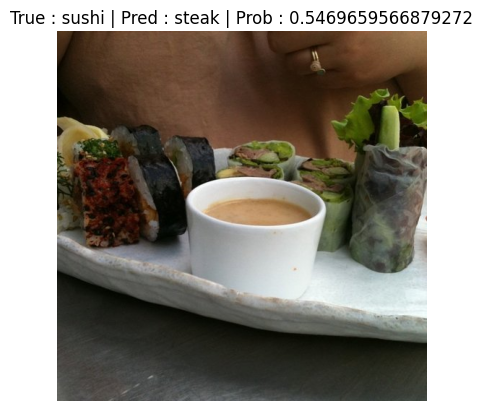

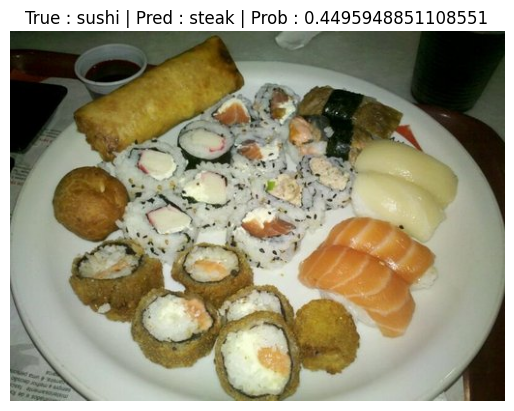

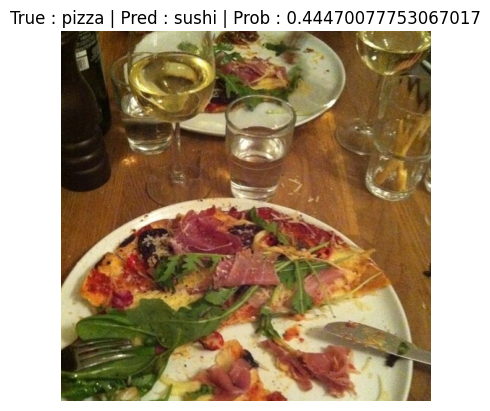

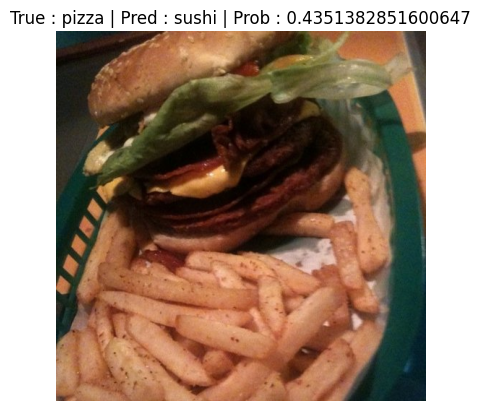

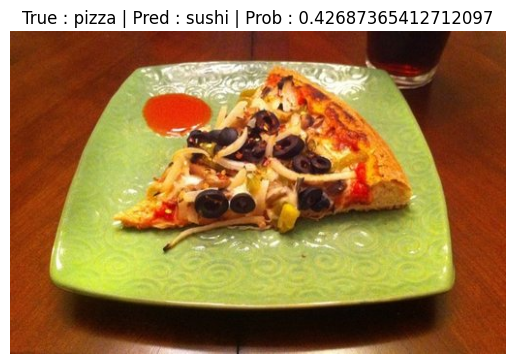

In [16]:
import torchvision
import matplotlib.pyplot as plt


for row in top_5_most_wrong.iterrows() :
  row = row[1]
  image_path = row[0]
  pred_prob = row[2]
  pred_class = row[3]
  true_label = row[1]

  img = torchvision.io.read_image(str(image_path))
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True : {true_label} | Pred : {pred_class} | Prob : {pred_prob}")
  plt.axis(False)
  plt.show()

##MODEL 1

In [17]:
## Model_!
import torchinfo

model_1 = torchvision.models.efficientnet_b0(pretrained = True).to(device)

for parm in model_1.features.parameters() :
  parm.requires_grad = False

model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2 , inplace = True)  ,
    torch.nn.Linear(in_features = 1280 ,
                    out_features = len(class_names),
                    bias = True )).to(device)


torchinfo.summary(model = model_1 , input_size = [32,3,224,224] ,
                  col_names= ['input_size' , 'output_size' , 'trainable' ])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

In [42]:
## Training for 10 epochs  train model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr= 0.001)

torch.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()

results_1 = engine.train(model = model_1 ,
                       train_dataloader = train_dataloader ,
                       test_dataloader = test_dataloader ,
                       optimizer = optimizer ,
                       loss_fn = loss_fn ,
                       epochs = 10  ,
                       device = device)
end_time = timer()

print(f"[INFO] : Total train time {end_time - start_time :.3f} seconds ")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1372 | train_acc: 0.2539 | test_loss: 1.0920 | test_acc: 0.3703
Epoch: 2 | train_loss: 1.1392 | train_acc: 0.3008 | test_loss: 1.0979 | test_acc: 0.3295
Epoch: 3 | train_loss: 1.1250 | train_acc: 0.3945 | test_loss: 1.0983 | test_acc: 0.3400
Epoch: 4 | train_loss: 1.1529 | train_acc: 0.2383 | test_loss: 1.1044 | test_acc: 0.3807
Epoch: 5 | train_loss: 1.1250 | train_acc: 0.2930 | test_loss: 1.0960 | test_acc: 0.3807
Epoch: 6 | train_loss: 1.1328 | train_acc: 0.3164 | test_loss: 1.1069 | test_acc: 0.3807
Epoch: 7 | train_loss: 1.1309 | train_acc: 0.3359 | test_loss: 1.1105 | test_acc: 0.3295
Epoch: 8 | train_loss: 1.1200 | train_acc: 0.2969 | test_loss: 1.1114 | test_acc: 0.3703
Epoch: 9 | train_loss: 1.1155 | train_acc: 0.4141 | test_loss: 1.1075 | test_acc: 0.3400
Epoch: 10 | train_loss: 1.1186 | train_acc: 0.4180 | test_loss: 1.0954 | test_acc: 0.3902
[INFO] : Total train time 18.343 seconds 


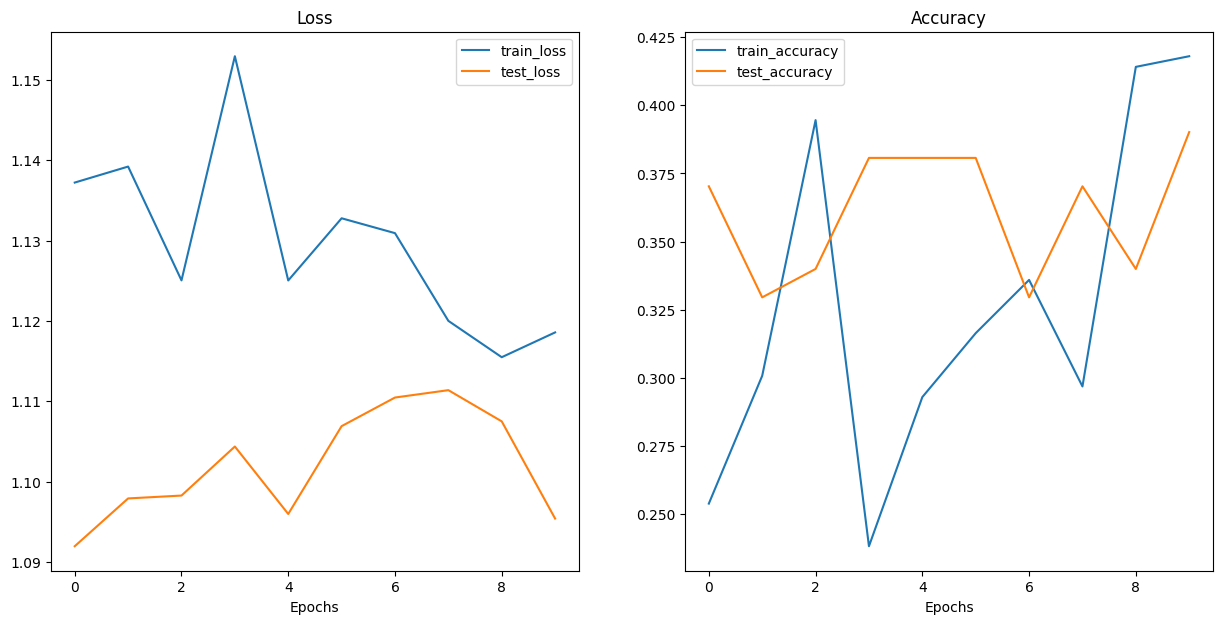

In [43]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it

plot_loss_curves(results_1)

##Training on more data
##MODEL 2

In [20]:
import os
import requests
import zipfile

from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    #  os.remove(data_path / image_data_zip_path)

train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [21]:

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
import torchvision

In [23]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7bd794ec74f0>,
 ['pizza', 'steak', 'sushi'])

In [24]:
# Pretrained Model

model_2 = torchvision.models.efficientnet_b0(pretrained = True).to(device)

for parm in model_2.features.parameters() :
  parm.requires_grad = False

torch.manual_seed(42)
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2 , inplace = True)  ,
    torch.nn.Linear(in_features = 1280 ,
                    out_features = len(class_names),
                    bias = True )).to(device)


In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters() , lr= 0.001)

In [26]:
## Training for 10 epochs  train model


torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_2 = engine.train(model = model_2 ,
                       train_dataloader = train_dataloader_20_percent ,
                       test_dataloader = test_dataloader_20_percent ,
                       optimizer = optimizer ,
                       loss_fn = loss_fn ,
                       epochs = 10  ,
                       device = device)
end_time = timer()

print(f"[INFO] : Total train time {end_time - start_time :.3f} seconds ")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.5667 | test_loss: 0.6472 | test_acc: 0.8949
Epoch: 2 | train_loss: 0.7067 | train_acc: 0.8167 | test_loss: 0.5291 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5866 | train_acc: 0.8271 | test_loss: 0.4519 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4555 | train_acc: 0.8917 | test_loss: 0.4089 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.4520 | train_acc: 0.8896 | test_loss: 0.3788 | test_acc: 0.9068
Epoch: 6 | train_loss: 0.4271 | train_acc: 0.8396 | test_loss: 0.3534 | test_acc: 0.9006
Epoch: 7 | train_loss: 0.4157 | train_acc: 0.8396 | test_loss: 0.3159 | test_acc: 0.9193
Epoch: 8 | train_loss: 0.3935 | train_acc: 0.8500 | test_loss: 0.3192 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3163 | train_acc: 0.8938 | test_loss: 0.3025 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.3488 | train_acc: 0.9042 | test_loss: 0.2699 | test_acc: 0.9318
[INFO] : Total train time 33.588 seconds 


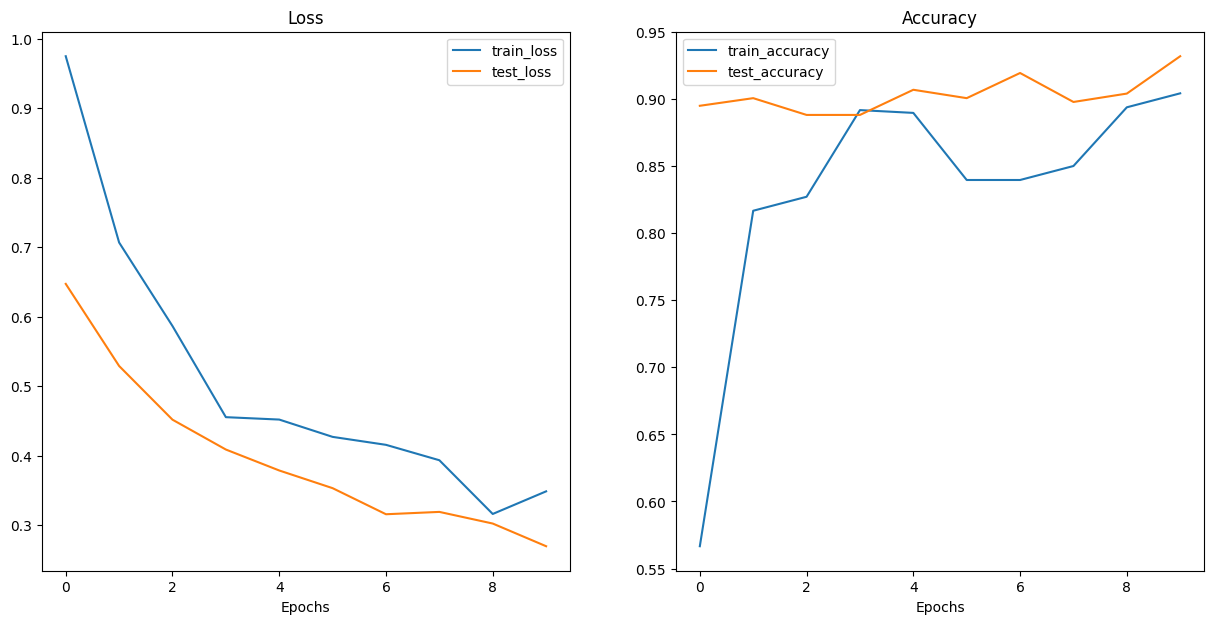

In [27]:
plot_loss_curves(results_2)

In [28]:

from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
  transforms.Resize((288, 288)), # effnet_b2 takes images of size 288, 288 - https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [29]:
train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [31]:
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b2_transform,
                                                                                                   batch_size=32)


##MODEL 3

In [32]:
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)


for param in model_3.parameters():
  param.requires_grad = False

torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 98.9MB/s]


In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b2,
                              test_dataloader=test_dataloader_effnet_b2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1112 | train_acc: 0.3242 | test_loss: 0.9117 | test_acc: 0.7027
Epoch: 2 | train_loss: 0.8985 | train_acc: 0.6719 | test_loss: 0.8660 | test_acc: 0.8352
Epoch: 3 | train_loss: 0.8051 | train_acc: 0.8008 | test_loss: 0.7908 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7409 | train_acc: 0.7695 | test_loss: 0.6717 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6484 | train_acc: 0.8047 | test_loss: 0.6559 | test_acc: 0.8769
[INFO] Total training time: 12.626 seconds


In [37]:

max(results["test_acc"]), min(results["test_loss"])

(0.8967803030303031, 0.6243551969528198)

In [44]:
max(results_1["test_acc"]), min(results_1["test_loss"])

(0.39015151515151514, 1.0919520060221355)

In [39]:
max(results_2["test_acc"]), min(results_2["test_loss"])

(0.9318181818181819, 0.26987218856811523)

In [40]:
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9280303030303031, 0.655890703201294)